# PokeClassifier

Gen1 Pokemon Image Classifier with Automatic Image Standardization

## Imports and Setup

In [1]:
# Setup to suppress gpu acceleration messages
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Datapaths and model hyperparameters

In [2]:
# Data location
train_path = 'TrainImages'
test_path = 'TestImages'

# Data perturbation and preprocessing
IMAGE_SHAPE = (224,224)
ROT_RANGE = 0.2
TRANS_RANGE = (-0.1, 0.1)
ZOOM_RANGE = (-0.05, 0.05)

# Model and Training
DROPOUT_PROP = 0.2
LEARNING_RATE = 0.001
EPOCH_TRAIN = 25 # Early stopping used, this is upper limit
BATCH_SIZE = 32
VAL_SPLIT = 0.1
FINE_TUNE_START = 140
EPOCH_FINE = 15 # Early stopping used, this is upper limit

## Initialize Image Generators

Utilize Keras's ImageDataGenerator to load both training and testing dataset images for the model. Will use 10% of the training set for validation when trainig the model. Since we have a small dataset, we introduce data augmentation in the generator with random flips, small rotations, and shifts to reduce overfitting.

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(train_path, 
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SHAPE,
                                             label_mode='categorical',
                                             labels='inferred',)

# Use 10% of training to form validation
train_batches = tf.data.experimental.cardinality(train_dataset)
val_dataset = train_dataset.take(train_batches // 10)

test_dataset = image_dataset_from_directory(test_path, shuffle=True, batch_size=BATCH_SIZE, image_size=IMAGE_SHAPE,label_mode='categorical', labels='inferred',)

# For displaying, import a loader with string labels
sample_dataset = image_dataset_from_directory(test_path, shuffle=True, image_size=IMAGE_SHAPE,)

Found 5830 files belonging to 149 classes.
Found 949 files belonging to 149 classes.
Found 949 files belonging to 149 classes.


### Sample images

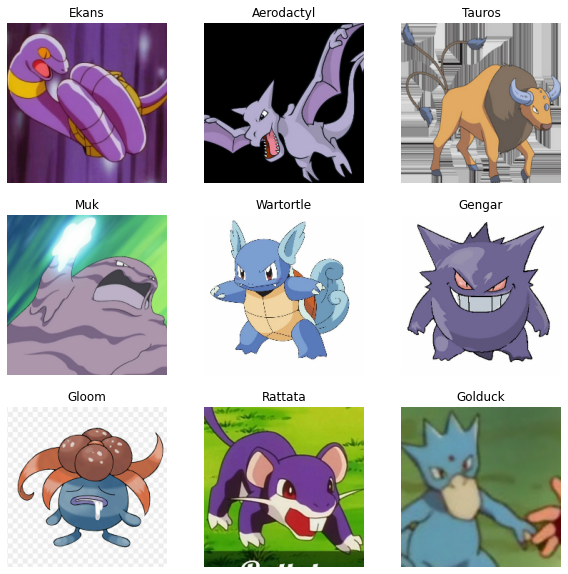

In [4]:
import matplotlib.pyplot as plt

class_labels = sample_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in sample_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

### Standardization and perturbation layer

In [5]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(ROT_RANGE),
    layers.RandomTranslation(TRANS_RANGE, TRANS_RANGE, fill_mode='nearest'),
    layers.RandomZoom(ZOOM_RANGE, ZOOM_RANGE, fill_mode='nearest'),
])

### Sample training images

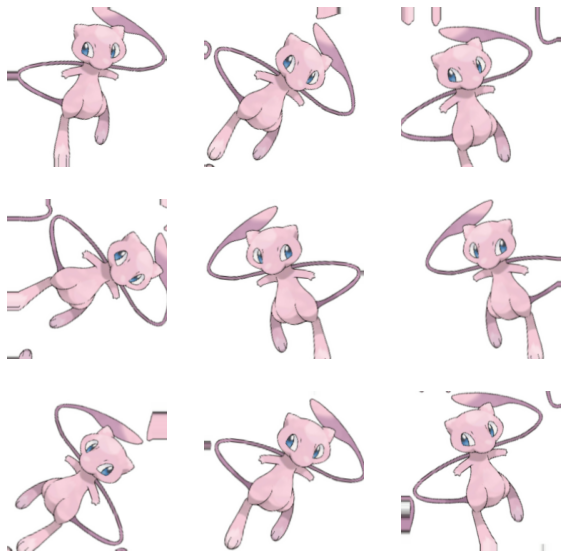

In [6]:
for image, _ in sample_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Preprocessing layer for base model

We will be using ResNet50 as our base model and thus need to use its preprocessing layer to properly format images.

In [7]:
from tensorflow.keras.applications import resnet50

preprocess_input = resnet50.preprocess_input

### Performance optimization

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Model Definition

We will use ResNet50 as our base model with our own classification head. Softmax activation will be used to convert the output into probabilities for each label in the output layer

### Base ResNet50 instantiation

In [9]:
INPUT_DIM = IMAGE_SHAPE + (3,)
base_model = resnet50.ResNet50(input_shape=INPUT_DIM,include_top=False,weights='imagenet')

base_model.trainable = False

### Classification head

In [10]:
# Average pooling layer to flatten ResNet CNN output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Output layer
output_layer = layers.Dense(149,activation='softmax')

### Building and compiling model

In [11]:
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_PROP)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

## Training

To best balance training and overfitting, we will utilize keras's EarlyStopping callback to halt training once overfitting is detected by a decrease in validation accuracy. Checkpointing is used to save the model with the best validation performance to be later fine tuned, evaluated, and used as a classifier.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint("poke_model.h5",
                                                monitor="val_loss",
                                                save_best_only=True,)
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2)

results = model.fit(train_dataset,
                    epochs=EPOCH_TRAIN,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, checkpoint],)

Epoch 1/80
183/183 [==============================] - 339s 2s/step - loss: 3.4870 - accuracy: 0.2806 - val_loss: 1.3577 - val_accuracy: 0.6649
Epoch 2/80
183/183 [==============================] - 317s 2s/step - loss: 1.3525 - accuracy: 0.6719 - val_loss: 0.7958 - val_accuracy: 0.8160
Epoch 3/80
183/183 [==============================] - 321s 2s/step - loss: 0.8957 - accuracy: 0.7739 - val_loss: 0.6111 - val_accuracy: 0.8663
Epoch 4/80
183/183 [==============================] - 316s 2s/step - loss: 0.6547 - accuracy: 0.8388 - val_loss: 0.4576 - val_accuracy: 0.8733
Epoch 5/80
183/183 [==============================] - 320s 2s/step - loss: 0.5234 - accuracy: 0.8662 - val_loss: 0.4104 - val_accuracy: 0.8976
Epoch 6/80
183/183 [==============================] - 321s 2s/step - loss: 0.4404 - accuracy: 0.8856 - val_loss: 0.3409 - val_accuracy: 0.9149
Epoch 7/80
183/183 [==============================] - 310s 2s/step - loss: 0.3856 - accuracy: 0.9000 - val_loss: 0.3103 - val_accuracy: 0.9115

KeyboardInterrupt: 

### Training summary

60/60 [==============================] - 17s 286ms/step - loss: 2.1454 - accuracy: 0.5279


<AxesSubplot: >

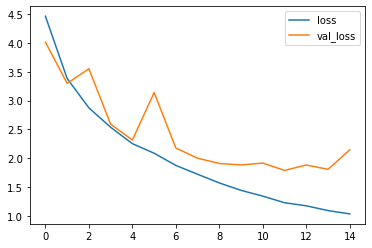

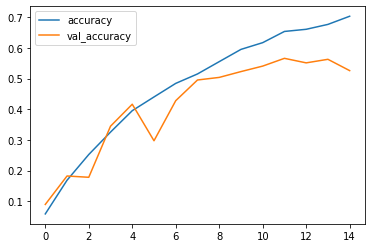

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

Train higher layers of the base model for this dataset for more performance

In [ ]:
# Load best version
model = tf.keras.models.load_model('poke_model.h5')

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:FINE_TUNE_START]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE/20),
              metrics=['accuracy'])

model.summary()

In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=EPOCH_TRAIN + EPOCH_FINE,
                         initial_epoch=results.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[early_stopping, checkpoint],)

### Fine tuning summary

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCH_TRAIN-1,EPOCH_TRAIN-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCH_TRAIN-1,EPOCH_TRAIN-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Final Evaluation

Evaluating performance on the testing dataset

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

## Predictions

TODO: Run random image through model, grab top three and print out